create simple model draft to get outlet embeddings 

In [181]:
import pandas as pd
import numpy as np
import torch 
from torchmetrics.functional.classification import f1_score
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm 
import random
import wandb 

In [6]:
# load in the news data of interest 
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t") 

<ipython-input-6-e2098ce75a41>:2: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t")


In [8]:
PICKLE_PATH = "/shared/3/projects/newsDiffusion/data/processed/IRTmodel/storyEmbeddingsMean.pkl"
storyEmbeddings = pd.read_pickle(PICKLE_PATH)

In [61]:
#we give a story cluster number and get back the average embedding for that story cluster 
storyDict = storyEmbeddings.set_index("clustNum")[["storyMean"]].to_dict()["storyMean"] 

#we want to get a list of all possible story clusters that an outlet can cover
allClusts = storyEmbeddings["clustNum"].tolist()

#keep only the articles that we have embeddings for, since we removed some clusters above
outletStoryDf = df.loc[df["clustNum"].isin(allClusts), ["source", "clustNum"]]

#now we have each outlet and stories it covered 
outletStoryDf = outletStoryDf.drop_duplicates()

In [62]:
clusteredStories = outletStoryDf.groupby("source").agg(set)
clusteredStories["covered"] = 1

notCoveredSamples = [] 
i = 0 
for source, currStories in tqdm(clusteredStories.iterrows()): 
    # we get the stories not covered by this outlet 
    # simply all stories minus the stories this outlet did cover 
    currStories = currStories["clustNum"]
    notCovered = set(allClusts) - currStories
    
    #take 1 times as many negative examples as positive 
    sample = random.sample(list(notCovered), 1 * len(currStories))
    notCoveredSamples.append((source, sample)) 

787it [00:12, 61.75it/s]


In [63]:
#create dataframe from samples of not covered stories 
notCoveredDf = pd.DataFrame(notCoveredSamples, columns=["source", "clustNum"])
notCoveredDf["covered"] = 0

#get covered/non-covered stories in long form 
clusteredStories = clusteredStories.reset_index().explode("clustNum")
notCoveredDf = notCoveredDf.explode("clustNum") 

#merge both covered and not covered training examples 
#a long form dataframe that gives us outlet, story cluster num, covered or not
allCoverage = pd.concat([notCoveredDf.reset_index(drop=True), clusteredStories.reset_index(drop=True)],axis=0) 

# mix up the rows so that we have equal number of pos/neg training examples 
# we reset index so we can troubleshoot cross val splits later on
allCoverage = allCoverage.sample(frac = 1).reset_index(drop=True)

### beginning of code for model training 

In [64]:
allCoverage.head()

,source,clustNum,covered
0,eveningstandard,142578.0,1
1,greeleytribune,165664.0,1
2,usnews,59894.0,0
3,theindependent,9395.0,0
4,globalresearch,2452.0,1


In [65]:
deviceNum = 2
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [101]:
class BasicModel(nn.Module):

    def __init__(self, numEmbeddings, embeddingLen, storyDict):
        super(BasicModel, self).__init__()
        self.embeddings = nn.Embedding(numEmbeddings, embeddingLen)
        self.storyDict = storyDict
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout()
        self.linear1 = nn.Linear(embeddingLen * 2, 200)
        self.linear2 = nn.Linear(200, 1) 
    
    #input will be the indices of the embeddings 
    def forward(self, embedIds, storyVecIds):
        #these are the outlet embeddings NOT the story embeddings 
        outletEmbeds = self.embeddings(embedIds) #.view((1, -1))
        storyVecs = torch.tensor([self.storyDict[int(clustNum)] for clustNum in storyVecIds], dtype=torch.float32).to(device)
        inTens = torch.concat((outletEmbeds, storyVecs), dim=1).to(device)
              
        out = self.ReLU(self.Dropout(self.linear1(inTens)))
        out = self.linear2(out)
        probs = self.Sigmoid(out)
        return probs
        

In [169]:
TOTAL_ROWS = 100000
trainDf = allCoverage.head(TOTAL_ROWS) 
dataset = Dataset.from_pandas(trainDf)
#trainDataset, validDataset = random_split(dataset, [.9, .1]) 

In [170]:
#embeds = nn.Embedding(len(outlets), 768)  # number of story clusters x length of BERT embeddings 
outlets = df["source"].unique()
outletDict = {outlets[i]:i for i in range(0, len(outlets))}

In [171]:

#optim = torch.optim.Adam(model.parameters(), lr=.0001)

# and setup a warmup for the first ~10% steps
#total_steps = int((len(trainDataset) * EPOCHS) / TRAIN_BATCH_SIZE)
#warmup_steps = int(0.1 * total_steps)

#scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)


#trainLoader = DataLoader(trainDataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
#validLoader = DataLoader(validDataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [172]:
def validate(validLoader): 
    #validation loop 
    allPreds = []
    allGts = []
    for batch in validLoader: 
        outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
        preds = model(outletLookups, batch["clustNum"].to(device))
        gts = torch.unsqueeze(batch["covered"], dim=1).to(device) 
        allPreds += preds.detach().squeeze().cpu().tolist()
        allGts += gts.detach().squeeze().cpu().tolist()
    return f1_score(torch.tensor(allPreds), torch.tensor(allGts)) 


In [186]:
int(TOTAL_ROWS * ((K_FOLDS - 1)/ K_FOLDS))

66666

In [183]:
loss_func = torch.nn.BCELoss()

TRAIN_BATCH_SIZE=100
VALID_BATCH_SIZE=200
EPOCHS=1
LR = .0001
# testing out cross validation

validTups = []
trainTups = []

K_FOLDS = 3
kfold = KFold(n_splits=K_FOLDS, shuffle=True)
config = {
    "lr":LR,
    "batchSize":TRAIN_BATCH_SIZE,
    "numFolds":K_FOLDS, 
    "trainFrac":TRAIN_FRAC,
    "totalExamples":TOTAL_ROWS,
    "trainExamples":TOTAL_ROWS * ((K_FOLDS - 1)/ K_FOLDS),
    "loss":"Binary Cross Entropy"
}
wandb.init(dir="/shared/3/projects/newsDiffusion/models/IRTModelling/",reinit=True, config=config,group="group")

In [173]:
for fold, (trainIds, validIds) in enumerate(kfold.split(trainDf)):
    
    model = BasicModel(len(outlets) , 768, storyDict) 
    model.to(device)
    model.train()
    
    print(f"fold: {fold}")
    
    trainDataset = Dataset.from_pandas(trainDf.iloc[trainIds,])
    validDataset = Dataset.from_pandas(trainDf.iloc[validIds,])
    
    trainLoader = DataLoader(trainDataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    validLoader = DataLoader(validDataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
    
    # and setup a warmup for the first ~10% steps
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    total_steps = int((len(trainDataset) * EPOCHS) / TRAIN_BATCH_SIZE)
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)
    
    subLossList = []
    i = 0 
    for batch in tqdm(trainLoader): 
        model.train()
        optim.zero_grad()
        
        #get the outlet ids from the outlet names fed into lookup dictionary  
        outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
        preds = model(outletLookups, batch["clustNum"].to(device))

        #get ground truth labels from the batch 
        gts = torch.unsqueeze(batch["covered"], dim=1).type("torch.FloatTensor").to(device) 

        loss = loss_func(preds, gts)
        loss.backward()
        optim.step()
        scheduler.step()
        subLossList.append(loss.detach().item())
        if i % 100 == 0:
            model.eval()
            #print(validate())
            validTups.append((fold, i, validate(validLoader)))
            trainTups.append((fold, i, np.mean(subLossList)))
            subLossList = []
            model.train()
        i += 1

fold: 0


100%|██████████| 667/667 [00:46<00:00, 14.23it/s]


fold: 1


100%|██████████| 667/667 [00:47<00:00, 14.18it/s]


fold: 2


100%|██████████| 667/667 [00:46<00:00, 14.40it/s]


In [174]:
validDf = pd.DataFrame(validTups, columns=["fold", "batch", "f1"])

In [175]:
validDf["f1"] = [item.item() for item in validDf["f1"]]

(array([ 3.,  2.,  9., 10.,  9.,  9., 13.,  8.,  1.,  3.]),
 array([0.41491768, 0.43500285, 0.45508802, 0.47517319, 0.49525836,
        0.51534353, 0.5354287 , 0.55551387, 0.57559904, 0.59568422,
        0.61576939]),
 <BarContainer object of 10 artists>)

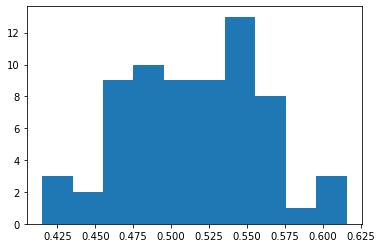

In [176]:
plt.hist(preds.squeeze().tolist()) 

In [177]:
trainEvalDf = pd.DataFrame(trainTups, columns=["fold", "batch", "BCEloss"]) 

<AxesSubplot:xlabel='batch', ylabel='f1'>

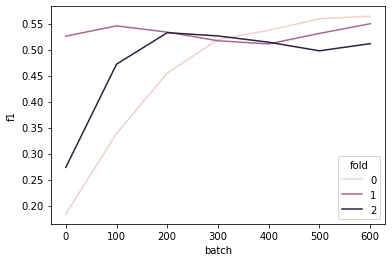

In [178]:
sns.lineplot(x="batch", y="f1", hue="fold", data=validDf) 

<AxesSubplot:xlabel='batch', ylabel='BCEloss'>

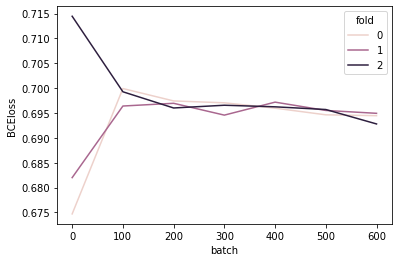

In [179]:
import seaborn as sns
sns.lineplot(x="batch", y="BCEloss", hue="fold", data=trainEvalDf) 